In [37]:

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox

In [38]:
from src import utils
from src.utils import print_title

In [39]:
import importlib
importlib.reload(utils)

<module 'src.utils' from '/Users/jobandtalent/Documents/GitHub/forecast-incremental-workflow/src/utils.py'>

## DATA INGESTION

### LOAD

In [40]:
day_df_raw = pd.read_csv('../data/day.csv')
display(day_df_raw.head())
print('DF Size: ', day_df_raw.shape)
print('DF Types: \n', day_df_raw.dtypes)

df = day_df_raw.copy()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


DF Size:  (731, 16)
DF Types: 
 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


### DTYPES

In [41]:
datetime_columns = ['dteday']
float64_columns = ['temp','atemp','hum','windspeed']
str_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
int64_columns = ['casual', 'registered', 'cnt']

# Basic data conversion
df = utils.format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)
# Rename columns
df.rename(columns={
    'dteday':'date',
    'yr':'year',
    'mnth':'month',
    'weathersit':'weather',
    'temp':'temperature',
    'atemp':'temperature_sensation',
    'hum':'humidity',
    'casual':'casual_users',
    'registered':'registered_users',
    'cnt':'bikes_rented'
}, inplace=True)
# Drop not used columns
df.drop(columns=['instant'], inplace=True)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

------------------- CONVERTED DATA TYPES -------------------
date                     datetime64[ns]
season                           object
year                             object
month                            object
holiday                          object
weekday                          object
workingday                       object
weather                          object
temperature                     float64
temperature_sensation           float64
humidity                        float64
windspeed                       float64
casual_users                      Int64
registered_users                  Int64
bikes_rented                      Int64
dtype: object


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## DATA CLEANING AND QA

### DESCRIBE

In [42]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('DISTRIBUTIONS')
display(df['season'].value_counts().sort_index())
display(df['year'].value_counts().sort_index())
display(df['month'].value_counts().sort_index())
display(df['holiday'].value_counts().sort_index())
display(df['weekday'].value_counts().sort_index())
display(df['workingday'].value_counts().sort_index())
display(df['weather'].value_counts().sort_index())

------------------------- DF INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   731 non-null    datetime64[ns]
 1   season                 731 non-null    object        
 2   year                   731 non-null    object        
 3   month                  731 non-null    object        
 4   holiday                731 non-null    object        
 5   weekday                731 non-null    object        
 6   workingday             731 non-null    object        
 7   weather                731 non-null    object        
 8   temperature            731 non-null    float64       
 9   temperature_sensation  731 non-null    float64       
 10  humidity               731 non-null    float64       
 11  windspeed              731 non-null    float64       
 12  casu

None

----------------------- DF DESCRIBE -----------------------


,date,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented
count,731,731.000000,731.000000,731.000000,731.000000,731.0,731.0,731.0
mean,2012-01-01 00:00:00,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
min,2011-01-01 00:00:00,0.059130,0.079070,0.000000,0.022392,2.0,20.0,22.0
25%,2011-07-02 12:00:00,0.337083,0.337842,0.520000,0.134950,315.5,2497.0,3152.0
50%,2012-01-01 00:00:00,0.498333,0.486733,0.626667,0.180975,713.0,3662.0,4548.0
75%,2012-07-01 12:00:00,0.655417,0.608602,0.730209,0.233214,1096.0,4776.5,5956.0
max,2012-12-31 00:00:00,0.861667,0.840896,0.972500,0.507463,3410.0,6946.0,8714.0
std,NaN,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452


---------------------- DISTRIBUTIONS ----------------------


season
1    181
2    184
3    188
4    178
Name: count, dtype: int64

year
0    365
1    366
Name: count, dtype: int64

month
1     62
10    62
11    60
12    62
2     57
3     62
4     60
5     62
6     60
7     62
8     62
9     60
Name: count, dtype: int64

holiday
0    710
1     21
Name: count, dtype: int64

weekday
0    105
1    105
2    104
3    104
4    104
5    104
6    105
Name: count, dtype: int64

workingday
0    231
1    500
Name: count, dtype: int64

weather
1    463
2    247
3     21
Name: count, dtype: int64

### DUPLICATES

In [43]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

# of duplicated rows:  0
No duplicates in the DataFrame found.


In [44]:

primary_key_column = 'date'

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = primary_key_column))

    # Keep only the first following timestamp column order
    if primary_key_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='first')
        print('Kept the most recent row for each duplicated' +  primary_key_column)
    else:
        df = df.sort_values(primary_key_column).drop_duplicates(subset=primary_key_column, keep='first')
        print('Kept the most recent row for each duplicated ' + primary_key_column)

# of duplicated on date column: 0


### NULLS

In [45]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

------------------ NUMBER OF NULL VALUES ------------------
date                     0
season                   0
year                     0
month                    0
holiday                  0
weekday                  0
workingday               0
weather                  0
temperature              0
temperature_sensation    0
humidity                 0
windspeed                0
casual_users             0
registered_users         0
bikes_rented             0
dtype: int64


### OUTLIERS

In [46]:
target_columns = ['casual_users', 'registered_users', 'bikes_rented']

numeric_cols = df.drop(columns=target_columns, errors='ignore').select_dtypes(include=["number"])
outliers_df = utils.detect_outliers(numeric_cols, method="iqr")
outlier_rows = df.loc[outliers_df.any(axis=1)]
print_title('ANOMALY ROWS')
display(outliers_df[outliers_df['is_outlier']])

df["extreme_weather"] = outliers_df["is_outlier"].astype(int).astype(str)
display(df.head())

----------------------- ANOMALY ROWS -----------------------


,iqr_outlier,zscore_outlier,outlier_columns,is_outlier
44,True,False,[windspeed],True
49,True,False,"[humidity, windspeed]",True
68,True,False,[humidity],True
93,True,False,[windspeed],True
94,True,False,[windspeed],True
292,True,False,[windspeed],True
382,True,False,[windspeed],True
407,True,False,[windspeed],True
420,True,False,[windspeed],True
432,True,False,[windspeed],True


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,0
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0


## EDA

In [47]:
target_column = 'bikes_rented'
try:
    df.drop(columns=['registered_users', 'casual_users'], inplace= True)
except:
    pass
display(df.head())

,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


In [48]:
def plot_time_series(df, time_series, p_alpha = 0.9, p_linestyle = "--"):
    fig, ax = plt.subplots(figsize=(20,6))
    
    colors = plt.get_cmap("tab10")(range(len(time_series)))
    for i, serie in enumerate(time_series):
        alpha = p_alpha if i > 0 else 1
        linestyle = p_linestyle if i > 0 else "-"
        
        ax.plot(df['date'], df[serie], label=serie, linewidth=2, color=colors[i], alpha=alpha, linestyle=linestyle)

    ax.set_title("Bikes rented", fontsize=14, fontweight='bold')

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis='y', labelsize=10)

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(frameon=False, fontsize=12)

    plt.show()

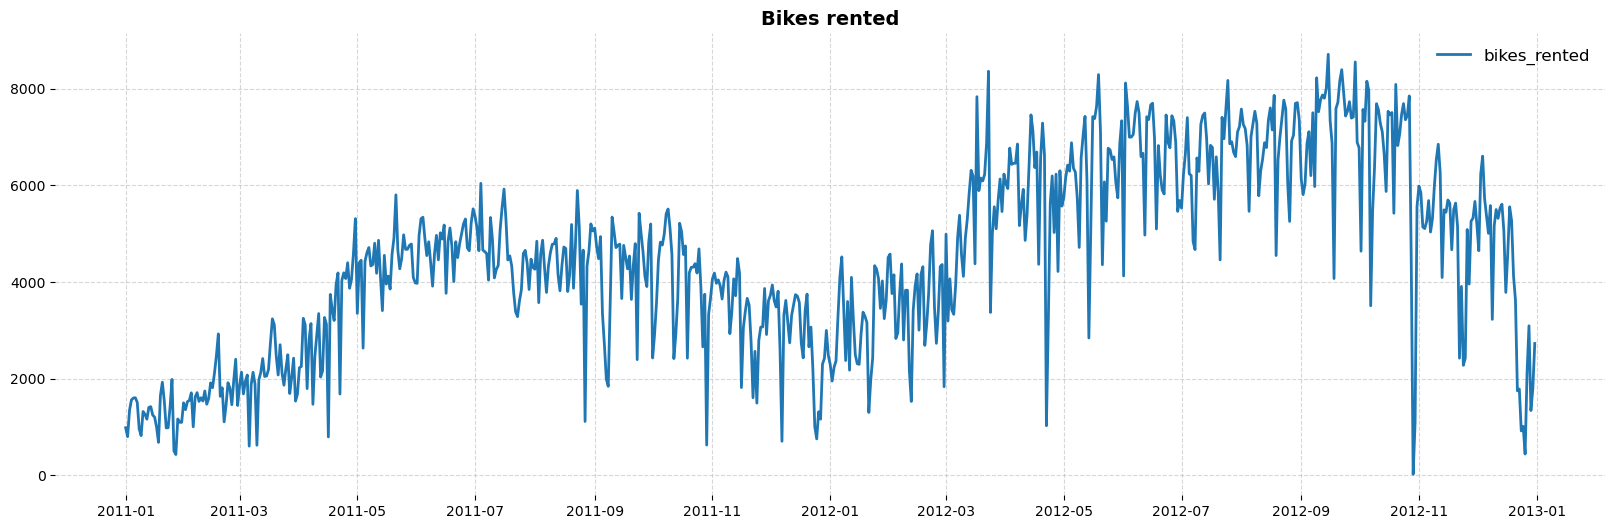

In [49]:
plot_time_series(df, [target_column], 0.9, '--')

### STATIONARITY

In [50]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["bikes_rented"])
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")
print("Conclusion:", "Stationary" if result[1] < 0.05 else "Non-stationary")

ADF Statistic: -1.8774481444374296
P-value: 0.34274344033921944
Conclusion: Non-stationary


### TREND

In [51]:
from statsmodels.tsa.stattools import kpss

result = kpss(df["bikes_rented"], regression="c")
print(f"KPSS Statistic: {result[0]}")
print(f"P-value: {result[1]}")
print("Conclusion:", "Trend present" if result[1] < 0.05 else "No significant trend")

KPSS Statistic: 2.424033427910016
P-value: 0.01
Conclusion: Trend present


/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_78831/288241163.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df["bikes_rented"], regression="c")


### TIME PERSISTENCE AND SEASONALITY

In [52]:
import numpy as np
from statsmodels.tsa.stattools import acf

nlags = 365
acf_values = acf(df["bikes_rented"], nlags=nlags, fft=True)

autocorrelated_lags = np.where(np.abs(acf_values) > 0.5)[0]
autocorrelation_ratio = len(autocorrelated_lags) / nlags

seasonal_lags = [lag for lag in autocorrelated_lags if lag % 7 == 0 or lag % 30 == 0 or lag % 365 == 0]

print(f"Lags with autocorrelation: {autocorrelated_lags.tolist()}")
print(f"Percentage of significant lags: {autocorrelation_ratio:.2%}")
print(f"Possible seasonal lags: {seasonal_lags}")

if autocorrelation_ratio > 0.5:
    print("Strong temporal dependence detected.")
elif autocorrelation_ratio > 0.3:
    print("Moderate temporal dependence detected.")
else:
    print("Low temporal dependence.")

if len(seasonal_lags) > 2:
    print("Seasonality detected.")
else:
    print("No clear seasonality.")

Lags with autocorrelation: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51]
Percentage of significant lags: 13.97%
Possible seasonal lags: [0, 7, 14, 21, 28, 30, 35, 42, 49]
Low temporal dependence.
Seasonality detected.


### ACF AND PACF

In [53]:
def plot_acf_and_pacf(input_df, additional_text = ''):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    plot_acf(input_df, ax=axes[0], lags=50)
    plot_pacf(input_df, ax=axes[1], lags=50)

    axes[0].set_title("ACF" + additional_text, fontsize=14, fontweight='bold')
    axes[1].set_title("PACF" + additional_text, fontsize=14, fontweight='bold')

    for ax in axes:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()

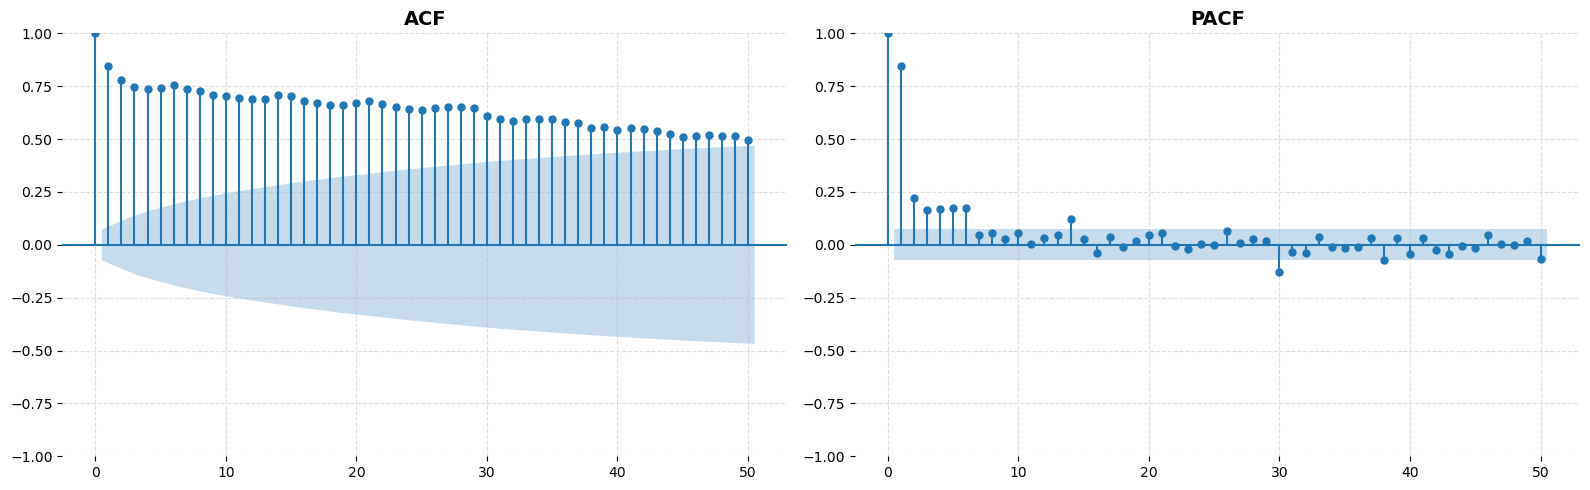

In [54]:
plot_acf_and_pacf(df[target_column])

### DECOMPOSITION

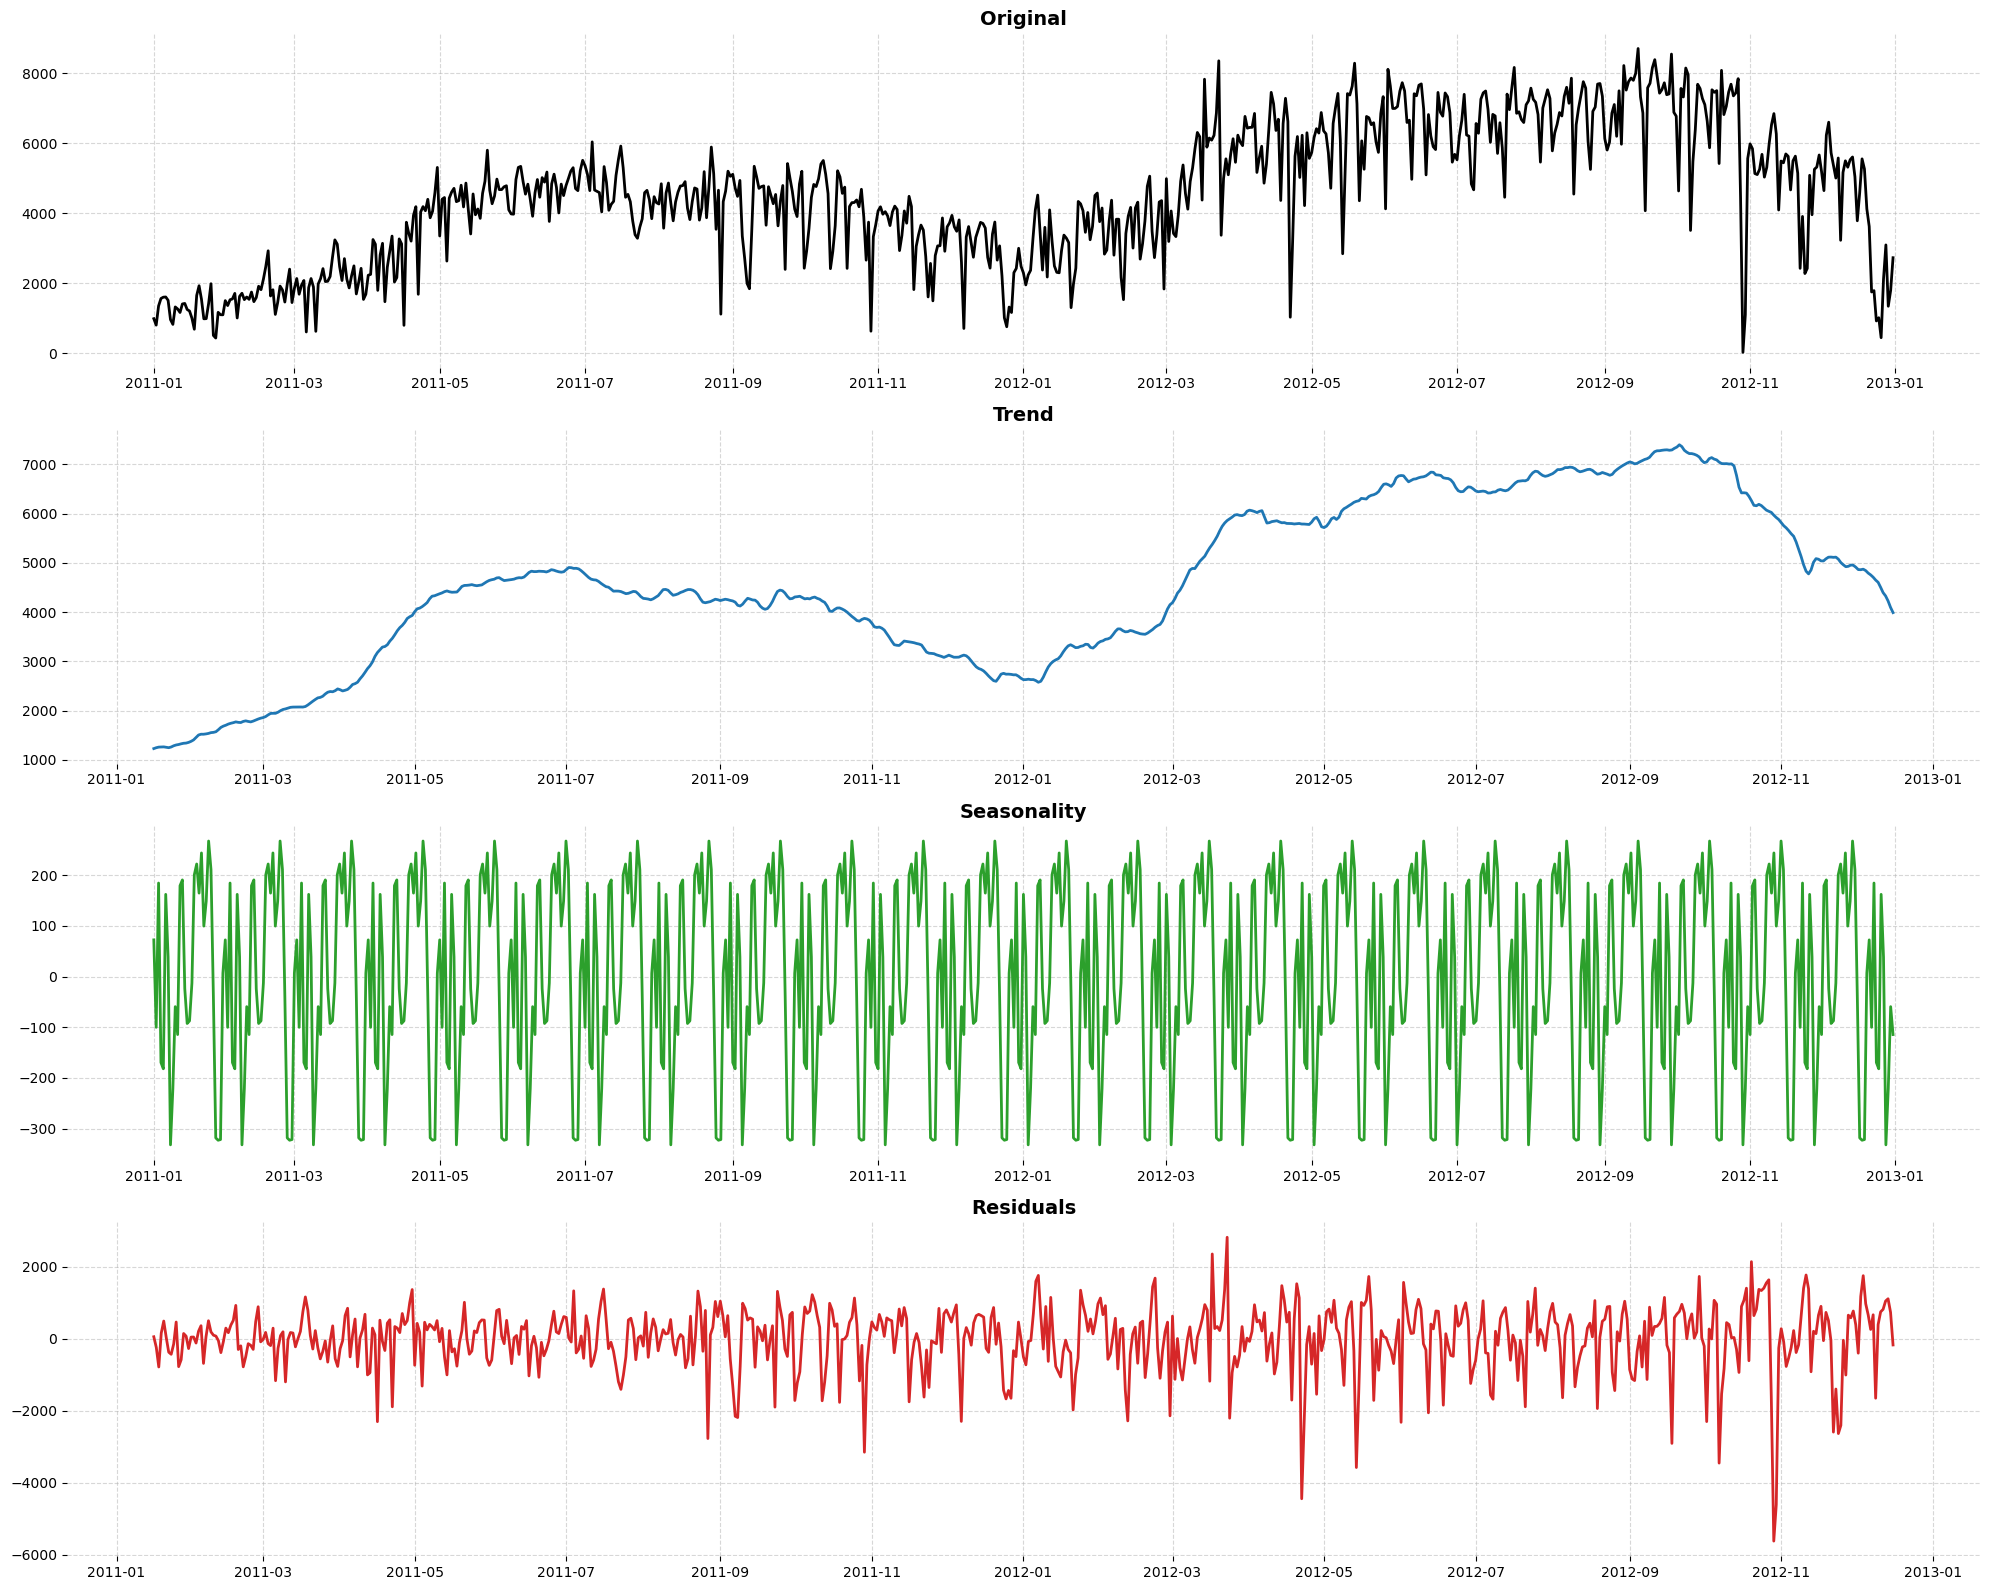

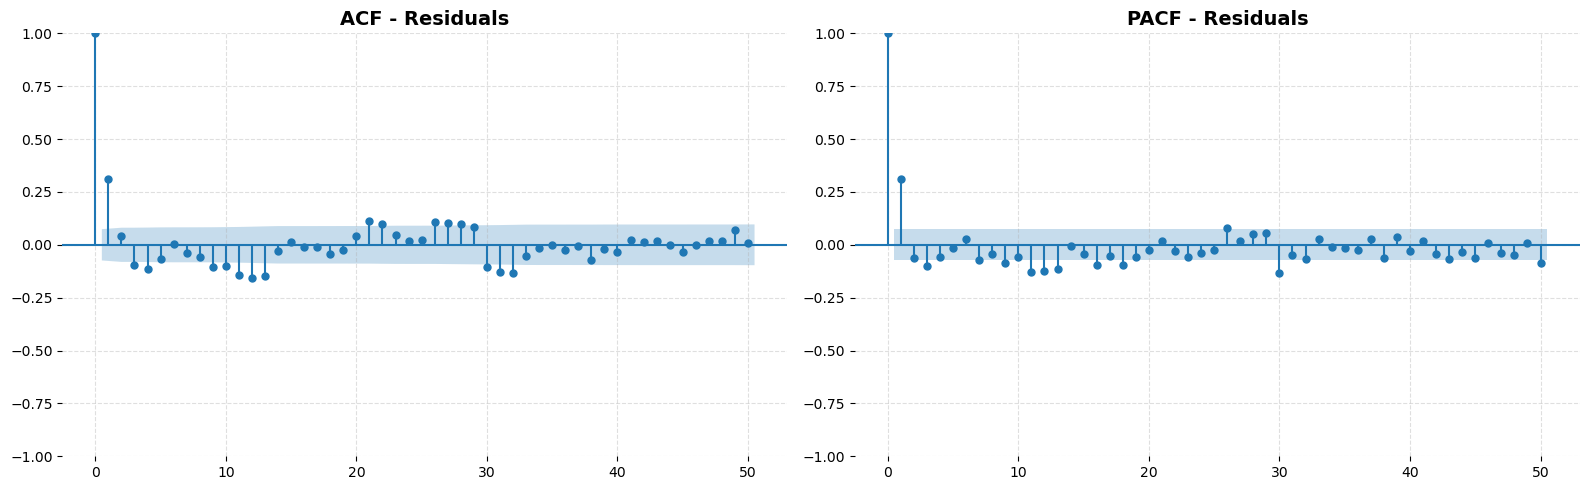

In [55]:
decomposed = seasonal_decompose(df[target_column], model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(20, 16))

axes[0].plot(df["date"], decomposed.observed, color="black", linewidth=2)
axes[0].set_title("Original", fontsize=14, fontweight='bold')

axes[1].plot(df["date"], decomposed.trend, color="tab:blue", linewidth=2)
axes[1].set_title("Trend", fontsize=14, fontweight='bold')

axes[2].plot(df["date"], decomposed.seasonal, color="tab:green", linewidth=2)
axes[2].set_title("Seasonality", fontsize=14, fontweight='bold')

axes[3].plot(df["date"], decomposed.resid, color="tab:red", linewidth=2)
axes[3].set_title("Residuals", fontsize=14, fontweight='bold')

for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis='x', rotation=0, labelsize=10)

plt.tight_layout()
plt.show()

plot_acf_and_pacf(decomposed.resid.dropna(), ' - Residuals')

### OUTLIERS

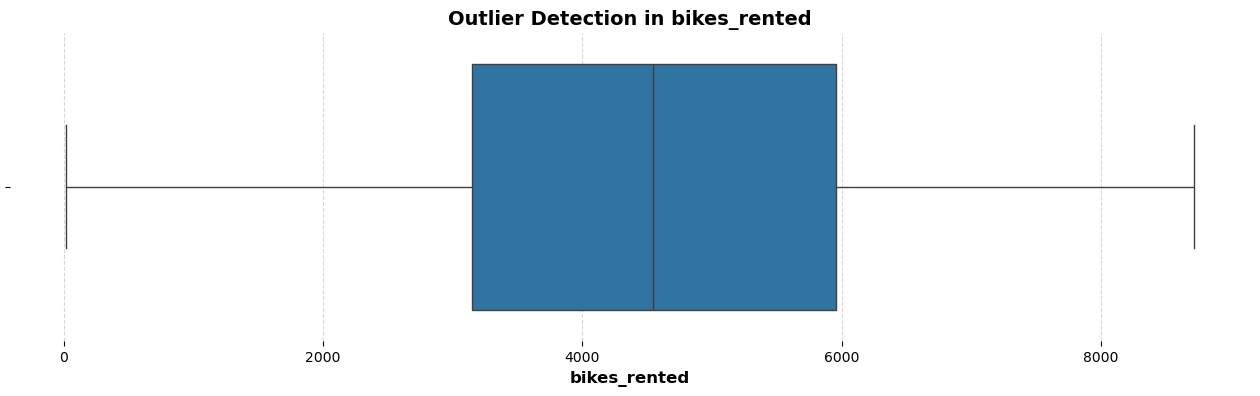

In [56]:
fig, ax = plt.subplots(figsize=(16,4))

sns.boxplot(
    x=df[target_column], 
    ax=ax, 
    flierprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black", "markersize": 6}
)

ax.set_title(f"Outlier Detection in {target_column}", fontsize=14, fontweight="bold")
ax.set_xlabel(target_column, fontsize=12, fontweight="bold")

for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

### EXOGENS

In [57]:
excluded_columns = ["bikes_rented", "date"]

exogen_columns = [
    col for col in df.columns 
    if col not in excluded_columns and df[col].dtype in ["int64", "float64", "uint8", "object"]
]
print("Exogenous variables for forecasting:", exogen_columns)

Exogenous variables for forecasting: ['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'weather', 'temperature', 'temperature_sensation', 'humidity', 'windspeed', 'extreme_weather']


### NUMERIC CORRELATION AND COLLINEARITY

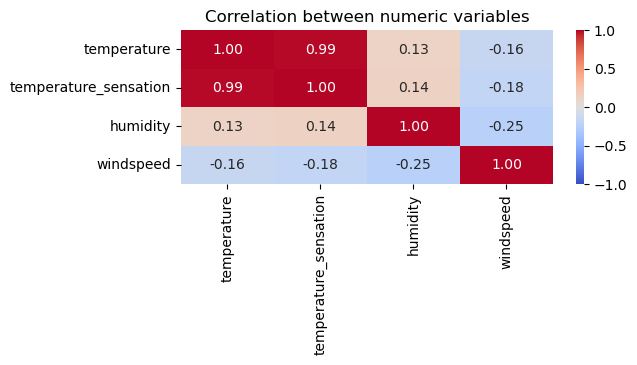

In [58]:
plt.figure(figsize=(6, 2))
df_numeric_to_corr = df.select_dtypes(include=["number"]).drop(columns=[target_column], errors="ignore")
df_corr = df_numeric_to_corr.corr()
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between numeric variables")
plt.show()

In [59]:
X = df_numeric_to_corr.dropna().select_dtypes(include=["number"]).astype("float64")

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

corr_matrix = X.corr().abs()
high_corr_pairs = np.where(corr_matrix > 0.8)
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j]) 
                   for i, j in zip(*high_corr_pairs) if i != j and i < j]

print("Highly correlated variable pairs:", high_corr_pairs)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print('\n')
print("VIF:")
print(vif_data)

target_corr = df.corr()["bikes_rented"].drop(["bikes_rented", "date"])
print('\n')
print("ABS Correlation values:")
print(abs(target_corr).sort_values(ascending=False))

Highly correlated variable pairs: [('temperature', 'temperature_sensation')]


VIF:
                Variable         VIF
1  temperature_sensation  543.242186
0            temperature  488.553062
2               humidity   11.064126
3              windspeed    4.682492


ABS Correlation values:
temperature_sensation    0.631066
temperature              0.627494
year                     0.566710
season                   0.406100
weather                  0.297391
month                    0.279977
windspeed                0.234545
extreme_weather          0.105338
humidity                 0.100659
holiday                  0.068348
weekday                  0.067443
workingday               0.061156
Name: bikes_rented, dtype: float64


## BASE FORECAST FEATURE ENGINEERING

### FEATURE SELECTION

In [60]:
features_to_remove = set()
for pair in high_corr_pairs:
    feature_to_remove = pair[0] if abs(target_corr[pair[0]]) < abs(target_corr[pair[1]]) else pair[1]
    features_to_remove.add(feature_to_remove)

# Remove high VIF features (threshold >10)
high_vif_features = vif_data[vif_data["VIF"] > 10]["Variable"].tolist()
features_to_remove.update(high_vif_features)

# Select relevant features
selected_features = [feature for feature in exogen_columns if feature not in features_to_remove]
selected_features = sorted(selected_features, key=lambda x: abs(target_corr[x]), reverse=True)
print("Final selected exogenous variables:", selected_features)

Final selected exogenous variables: ['year', 'season', 'weather', 'month', 'windspeed', 'extreme_weather', 'holiday', 'weekday', 'workingday']


### TIME NORMALIZATION

In [61]:
use_time_normalization = False
df_selection = df.copy()
target_time_norm_column = target_column + "_time_norm"

if use_time_normalization:
    forecast_column = target_time_norm_column
    df_selection[forecast_column] = df[target_column] / df["date"].dt.days_in_month
    try:
        df_selection.drop(columns=target_column, inplace=True)
    except:
        pass
else:
    forecast_column = target_column
    try:
        df_selection.drop(columns=target_time_norm_column, inplace=True)
    except:
        pass

print('Forecast variable: ', forecast_column)
display(df_selection.head(1))

Forecast variable:  bikes_rented


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0


### TRANSFORMATIONS

In [62]:
def check_transformations(df_selection):
    numeric_vars = df_selection.select_dtypes(include=["number"]).columns
    transformations_needed = {}

    for col in numeric_vars:
        result = {}

        p_value = adfuller(df_selection[col].dropna())[1]
        result["stationary"] = p_value < 0.05  # True = Stationary, False = Not Stationary
        
        if not result["stationary"]:  # If not stationary
            if df_selection[col].min() > 0:  # Check if all values are positive
                boxcox_lambda = boxcox(df_selection[col] + 1)[1]  # +1 to avoid log(0) errors
                if abs(boxcox_lambda - 1) > 0.1:
                    result["recommended_transformation"] = "boxcox"
                else:
                    result["recommended_transformation"] = "log"
            else:
                result["recommended_transformation"] = "diff"
        else:
            result["recommended_transformation"] = "none"
        
        transformations_needed[col] = result

    transformations_df = pd.DataFrame(transformations_needed).T
    print(transformations_df)
    return transformations_df
        

def apply_transformations(df_selection, transformations):
    df_transformed = df_selection.copy()
    for col, row in transformations.iterrows():
        transformation = row["recommended_transformation"]
        
        if transformation == "diff":
            df_transformed[col] = df_selection[col].diff().dropna()
        elif transformation == "log":
            df_transformed[col] = np.log1p(df_selection[col])  # log1p avoids log(0) issues
        elif transformation == "boxcox":
            df_transformed[col], _ = boxcox(df_selection[col] + 1)  # +1 to handle zero values

    print("Transformations applied successfully.")
    display(df_transformed.head())
    return df_transformed

In [63]:
df_selection = df_selection[['date'] + selected_features + [forecast_column]]

print_title('Recommended Transformations')
transformations = utils.check_transformations(df_selection)

print('\n')
print_title('DF Prepared')
df_transformed = utils.apply_transformations(df_selection, transformations)
print('Forecast variable: ', forecast_column)

--------------- Recommended Transformations ---------------
             stationary recommended_transformation
windspeed          True                       none
bikes_rented      False                     boxcox


----------------------- DF Prepared -----------------------
Transformations applied successfully.


,date,year,season,weather,month,windspeed,extreme_weather,holiday,weekday,workingday,bikes_rented
0,2011-01-01,0,1,2,1,0.160446,0,0,6,0,499.329506
1,2011-01-02,0,1,2,1,0.248539,0,0,0,0,415.834439
2,2011-01-03,0,1,1,1,0.248309,0,0,1,1,659.495676
3,2011-01-04,0,1,1,1,0.160296,0,0,2,1,750.805907
4,2011-01-05,0,1,1,1,0.186900,0,0,3,1,766.938328


Forecast variable:  bikes_rented


## BASELINE AND VALIDATION

### BASELINE

In [ ]:
def naive_forecast(df, forecast_column, date_column="date", steps=30):
    df_forecast = df.copy()
    
    df_forecast[date_column] = pd.to_datetime(df_forecast[date_column])
    
    df_forecast["naive_forecast"] = df_forecast[forecast_column].shift(1)
    df_forecast["is_future_forecast"] = False  # Mark historical data

    time_deltas = df_forecast[date_column].diff().dropna()
    most_common_delta = time_deltas.mode()[0] if not time_deltas.empty else pd.Timedelta(days=1)

    last_date = df_forecast[date_column].iloc[-1]
    future_dates = [last_date + most_common_delta * i for i in range(1, steps + 1)]

    future_forecast = pd.DataFrame(index=range(steps), columns=df.columns)
    future_forecast[date_column] = future_dates  # Assign new future dates
    future_forecast[forecast_column] = None  # No real values for the future
    future_forecast["naive_forecast"] = df_forecast[forecast_column].iloc[-1]  # Naïve prediction
    future_forecast["is_future_forecast"] = True  # Mark as future data

    df_final = pd.concat([df_forecast, future_forecast], ignore_index=True)

    return df_final

In [101]:
df_naive_forecast = naive_forecast(df_transformed, forecast_column, steps=60)
baseline_forecast_column = 'naive_forecast'

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_78831/2295522181.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_forecast, future_forecast], ignore_index=True)


In [102]:
def plot_time_series_forecast(df, time_series, p_alpha=0.9, p_linestyle="--", plot_ci = True, use_ci_scale_factor = False):
    fig, ax = plt.subplots(figsize=(20,6))
    
    colors = plt.get_cmap("tab10")(range(len(time_series)))
    future_mask = df["is_future_forecast"] == True

    if len(time_series) > 1:
        first_future_date = df.loc[future_mask, "date"].min()
    else:
        first_future_date = None
        
    for i, serie in enumerate(time_series):
        alpha = p_alpha if i > 0 else 1
        linestyle = p_linestyle if i > 0 else "-"

        ax.plot(df["date"], df[serie], label=serie, linewidth=2, color=colors[i], alpha=alpha, linestyle=linestyle)

        if i > 0 and plot_ci:
            mean_forecast = df.loc[future_mask, serie]
            std_dev = df.loc[~future_mask, forecast_column].std()  # Use historical std dev
            
            forecast_horizon = np.arange(1, len(mean_forecast) + 1)
            
            if use_ci_scale_factor:
                scale_factor = np.log1p(forecast_horizon)
            else:
                scale_factor = 1

            lower_80 = mean_forecast - 1.28 * std_dev * scale_factor
            upper_80 = mean_forecast + 1.28 * std_dev * scale_factor
            lower_95 = mean_forecast - 1.96 * std_dev * scale_factor
            upper_95 = mean_forecast + 1.96 * std_dev * scale_factor
            
            ax.fill_between(df.loc[future_mask, "date"], lower_95, upper_95, color=colors[i], alpha=0.2, label=f"{serie} 95% CI")
            ax.fill_between(df.loc[future_mask, "date"], lower_80, upper_80, color=colors[i], alpha=0.4, label=f"{serie} 80% CI")


    if first_future_date:
        ax.axvline(first_future_date, color="black", linestyle="-", linewidth=2, alpha = 0.3,  label="Forecast Start")

    ax.set_title("Bikes Rented Forecast", fontsize=14, fontweight="bold")

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis="y", labelsize=10)

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(frameon=False, fontsize=12)

    plt.show()

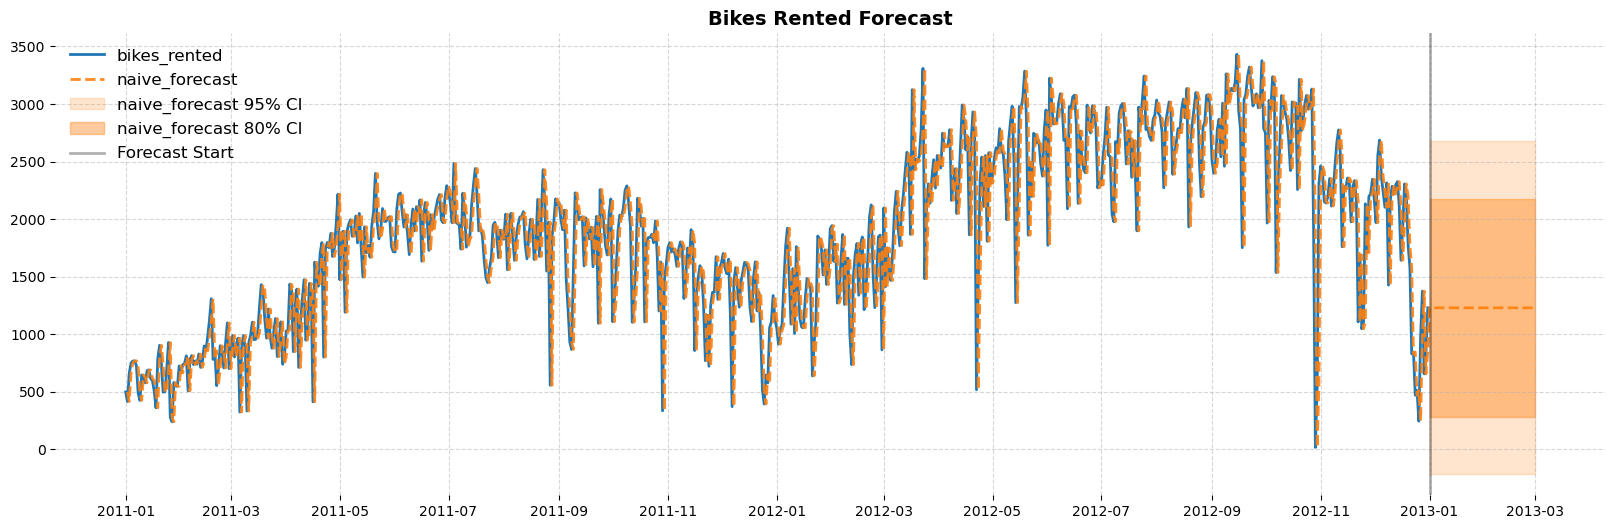

In [103]:
plot_time_series_forecast(df_naive_forecast, [forecast_column, 'naive_forecast'], 0.9, '--', True)


### VALIDATION

## BASE FORECASTING

## STATISTICAL FORECASTING

## ML FORECAST FEATURE ENGINEERING

#### COMPLETE CORRELATION AND COLLINEARITY

In [ ]:
plt.figure(figsize=(20, 16))
df_encoded_to_corr = pd.get_dummies(df.drop(columns=[target_column, "date"], errors="ignore"), drop_first=True)
df_corr = df_encoded_to_corr.corr()
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between all variables")
plt.show()